
## Repository
Clone https://github.com/jlunder00/OpenGlue

## Data
First, download/unzip data as shown in README.md:

### Steps to prepare MegaDepth dataset for training
1) Create folder `MegaDepth`, where your dataset will be stored.
   ```
   mkdir MegaDepth && cd MegaDepth
   ```
2) Download and unzip `MegaDepth_v1.tar.gz` from official [link](https://www.cs.cornell.edu/projects/megadepth/dataset/Megadepth_v1/MegaDepth_v1.tar.gz).
You should now be able to see `MegaDepth/phoenix` directory.
3) We provide the lists of pairs for training and validation, [link](https://drive.google.com/file/d/1DQl6N1bKEdzlRteCVMS1bWffz0SU-L9x/view?usp=sharing) to download. Each line corresponds to one pair and has the following structure:
```
path_image_A path_image_B exif_rotationA exif_rotationB [KA_0 ... KA_8] [KB_0 ... KB_8] [T_AB_0 ... T_AB_15] overlap_AB
```
`overlap_AB` - is a value of overlap between two images of the same scene, it shows how close (in position transformation) two images are. 

The resulting directory structure should be as follows:
```
MegaDepth/
   - pairs/
   |   - 0000/
   |   |   - sparse-txt/
   |   |   |    pairs.txt
      ...
   - phoenix/S6/zl548/MegaDepth_v1/
   |   -0000/
   |   |   - dense0/
   |   |   |   - depths/
   |   |   |   |   id.h5
                 ...
   |   |   |   - images/
   |   |   |   |   id.jpg
                 ...
   |   |   - dense1/
            ...
      ...
```

The directory structure needs to be the same as shown, even if the data being used is different. To train on different data, create the same directory structure and with data files in the same format. The folder marked 0000/ above represents that everything inside is a part of the same "scene". In the case of the included dataset, images of the same building from different angles/lightings/etc are considered part of the same scene. The format for pairs.txt is shown above, and is needed to add the additional info about pairs of images that OpenGlue uses in it's training. OpenGlue does not include code to generate these files.

## Take a Subset of the Data
OpenGlue includes files specifying which scenes (as in the folder names which each contain a single scene) are to be used for training, testing, and validation, but does not include code for generating new versions of these or for making a smaller sample set.
To take a subset of the data and only use a small amount in training and testing, we need to generate new versions of these files. However, OpenGlue has an intermediate step that is reccommended to be done prior to training, feature extraction, which does not utilize these files and extracts features (keypoints) from the images in the dataset. Feature extraction is highly expensive in terms of disk usage, and takes a long time to do, but speeds up training time. There is not a method implemented in OpenGlue to only preform feature extraction on a subset of the data, but alternatively, we can skip feature extraction as OpenGlue has 2 training methods, one which relies on feature extraction being done prior, and one which does it as training is done. By utilizing the latter, we can have OpenGlue preform feature extraction and training on only a subset of the data, since, although training time would be fastest with a subset and with feature extraction done prior, doing this will make the overall time to go from the beginning of the pipeline to the end faster.

Additionally, store test data in a seperate folder. OpenGlue tests via running inference on 2 jpg images. The images to test on are not provided by OpenGlue, but you can use kaggle data to test (https://www.kaggle.com/competitions/image-matching-challenge-2022/data?select=test_images) or use other images that are applicable 

In [1]:
#Generate files for train/validate split
import torch
import torch.utils.data as data
import os
import random
def split_data(root_data_dir, percent_used, validate_set_percent, split_config_dir, split_config_name):
    all_scenes = os.listdir(root_data_dir)
    sub_set = [scene for scene in all_scenes if random.random() <= percent_used] 
    print(sub_set)
    
    train_set_size = int(len(sub_set) * (1-validate_set_percent))
    valid_set_size = len(sub_set) - train_set_size
    
    seed = torch.Generator().manual_seed(42)
    train_set, valid_set = data.random_split(sub_set, [train_set_size, valid_set_size], generator=seed)
    print(train_set)
     
    sub_set_path = os.path.join(split_config_dir, split_config_name+'-total.txt')
    train_set_path = os.path.join(split_config_dir, split_config_name+'-train.txt')
    val_set_path = os.path.join(split_config_dir, split_config_name+'-val.txt')
    
    with open(sub_set_path, 'w') as fout:
        for scene in sub_set:
            fout.write(scene+'\n')
    with open(train_set_path, 'w') as fout:
        for scene in train_set:
            fout.write(scene+'\n')
    with open(val_set_path, 'w') as fout:
        for scene in valid_set:
            fout.write(scene+'\n')
    return train_set_path, val_set_path, sub_set_path

/root/code/OpenGlue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
split_data('/host_Data/Data/MegaDepth/MegaDepth/phoenix/S6/zl548/MegaDepth_v1', 0.025, 0.2, './assets/', 'subset-0025-02')

['0032', '0047', '0223', '0252']


('./assets/subset-0025-02-train.txt',
 './assets/subset-0025-02-val.txt',
 './assets/subset-0025-02-total.txt')

## Training with no pre-extraction

In [27]:
#From train.py

import torch
import shutup

shutup.please()
import os
import argparse
from datetime import datetime
from omegaconf import OmegaConf
import pytorch_lightning as pl

#Modified from importing DDPPlugin (depreciates)
from pytorch_lightning.strategies import DataParallelStrategy

from data.megadepth_datamodule import MegaDepthPairsDataModule
from models.matching_module import MatchingTrainingModule
from utils.train_utils import get_training_loggers, get_training_callbacks, prepare_logging_directory


def train(args):
    parser = argparse.ArgumentParser(description='Processing configuration for training')
    parser.add_argument('--config', type=str, help='path to config file', default='config/config.yaml')
    parser.add_argument('--features_config', type=str, help='path to config file with features', default='config/features_online/sift.yaml')
    args = parser.parse_args(args)

    # Load config
    config = OmegaConf.load('config/config.yaml')  # base config
    feature_extractor_config = OmegaConf.load(args.features_config)
    if args.config != 'config/config.yaml':
        add_conf = OmegaConf.load(args.config)
        config = OmegaConf.merge(config, add_conf)

    pl.seed_everything(int(os.environ.get('LOCAL_RANK', 0)))

    # Prepare directory for logs and checkpoints
    if os.environ.get('LOCAL_RANK', 0) == 0:
        experiment_name = '{}/{}__attn_{}__laf_{}__{}'.format(
            config['data']['experiments_root_path'],
            feature_extractor_config['name'],
            config['superglue']['attention_gnn']['attention'],
            config['superglue']['laf_to_sideinfo_method'],
            str(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        )
        log_path = prepare_logging_directory(config, experiment_name, features_config=feature_extractor_config)
    else:
        experiment_name, log_path = '', ''

    # Init Lightning Data Module
    data_config = config['data']
    dm = MegaDepthPairsDataModule(
        root_path=data_config['root_path'],
        train_list_path=data_config['train_list_path'],
        val_list_path=data_config['val_list_path'],
        test_list_path=data_config['test_list_path'],
        batch_size=data_config['batch_size_per_gpu'],
        num_workers=data_config['dataloader_workers_per_gpu'],
        target_size=data_config['target_size'],
        val_max_pairs_per_scene=data_config['val_max_pairs_per_scene'],
        train_pairs_overlap=data_config.get('train_pairs_overlap')
    )

    # Init model
    model = MatchingTrainingModule(
        train_config={**config['train'], **config['inference'], **config['evaluation']},
        features_config=feature_extractor_config,
        superglue_config=config['superglue'],
    )

    # Set callbacks and loggers
    callbacks = get_training_callbacks(config, log_path, experiment_name)
    loggers = get_training_loggers(config, log_path, experiment_name)

    # Init distributed trainer
    trainer = pl.Trainer(
        gpus=config['gpus'],
        max_epochs=config['train']['epochs'],
        accelerator="gpu", #Vital, with any other accelerator or no accelerator, resultant model will not be usable for inference test
        gradient_clip_val=config['train']['grad_clip'],
        log_every_n_steps=config['logging']['train_logs_steps'],
        limit_train_batches=config['train']['steps_per_epoch'],
        num_sanity_val_steps=0,
        callbacks=callbacks,
        logger=loggers,
        strategy=DataParallelStrategy(),
        #plugins=DDPPlugin(find_unused_parameters=False),
        precision=config['train'].get('precision', 32),
    )
    # If loaded from checkpoint - validate
    if config.get('checkpoint') is not None:
        trainer.validate(model, datamodule=dm, ckpt_path=config.get('checkpoint'))
    trainer.fit(model, datamodule=dm, ckpt_path=config.get('checkpoint'))

In [28]:
print(torch.cuda.device_count())
!nvcc --version
!python --version

print(torch._C._cuda_getCompiledVersion())
print(torch._C._cuda_getDevice())
print(torch._C._cuda_getDeviceCount())

1
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Python 3.8.10
11030
0
1


In [ ]:
args = ['--config', './config/config.yaml', '--features_config', './config/features/superpoint_magicleap.yaml']
train(args)

Global seed set to 0


<All keys matched successfully>


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jlunder. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                     | Type                      | Params
-----------------------------------------------------------------------
0 | local_features_extractor | SuperPointNet             | 1.3 M 
1 | superglue                | SuperGlue                 | 12.0 M
2 | augmentations            | AugmentationSequential    | 0     
3 | epipolar_dist_metric     | AccuracyUsingEpipolarDist | 0     
4 | camera_pose_auc_metric   | CameraPoseAUC             | 0     
-----------------------------------------------------------------------
12.0 M    Trainable params
1.3 M     Non-trainable params
13.3 M    Total params
53.032    Total estimated model params size (MB)


Epoch 0:  94%|█████████▍| 750/800 [04:34<00:18,  2.73it/s, loss=3.73, v_num=q10i, Train NLL loss=3.140, Train Metric loss=0.000]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]correction?

Epoch 0:  94%|█████████▍| 751/800 [04:35<00:17,  2.73it/s, loss=3.73, v_num=q10i, Train NLL loss=3.140, Train Metric loss=0.000]correction?

Epoch 0:  94%|█████████▍| 752/800 [04:35<00:17,  2.73it/s, loss=3.73, v_num=q10i, Train NLL loss=3.140, Train Metric loss=0.000]correction?

Epoch 0:  94%|█████████▍| 753/800 [04:36<00:17,  2.72it/s, loss=3.73, v_num=q10i, Train NLL loss=3.140, Train Metric loss=0.000]correction?

Epoch 0:  94%|█████████▍| 754/800 [04:37<00:16,  2.72it/s, loss=3.73, v_num=q10i, Train NLL loss=3.140, Train Metric loss=0.000]correction?

Epoch 0:  94%|█████████▍| 755/800 [04:37<00:16,  2.72it/s, loss=3.73, v_num=q10i, Train NLL loss=3.140, Train Metric loss=0.000]correction?

Epoch 0:  94%|█████████▍| 756/800 [04:38<00:16,  2.72it/s, 

## Inference

In [3]:
import inference
import matplotlib.pyplot as plt

import kornia as K
import kornia.feature as KF
from kornia_moons.feature import *

import torch
import torch.nn as nn

#Where the images to run inference on are
img0_path = '/host_Data/Data/MegaDepth/MegaDepth/test_images/img2.jpg'
img1_path = '/host_Data/Data/MegaDepth/MegaDepth/test_images/img3.jpg'

#Where the configurations and checkpoints saved during training are

#trained with DataParallelStrategy in Jupyter, 
experiment_path = '/host_Data/Data/MegaDepth/MegaDepth/extracted_features/phoenix3/SuperPointNet__attn_softmax__laf_none__2022-06-14-23-47-02'

#trained with DDPStrategy in non-interactive openglue environment, inference works after correcting incorrectly loaded local_features_extractor weights and biases from statedict
#experiment_path = '/host_Data/Data/MegaDepth/MegaDepth/extracted_features/phoenix3/SuperPointNet__attn_softmax__laf_none__2022-06-14-23-32-09'

checkpoint_name = 'superglue-step=750.ckpt'

#which device to use to run inference (gpu or cpu)
device = 'cpu'

#output location
output_dir = 'results.png'

- Config.yaml in 'experiment_path' directory
    - Under superglue:
        - Add 'descriptor_dim: <dim>' where <dim> is the same as the corresponding field in features_config.yaml in the same folder (usually 256)
        - Under positional_encoding:
            - Add and set 'output_size: ' to the same value
        - Under attention_gnn:
            - Add and set 'embed_dim: ' to the same value
   
   

{'name': 'SuperPointNet', 'descriptor_dim': 256, 'parameters': {'max_keypoints': 2048, 'descriptor_dim': 256, 'nms_kernel': 9, 'remove_borders_size': 4, 'keypoint_threshold': 0.005, 'weights': './models/superglue/weights/superpoint_magicleap_v1.pth'}, 'max_keypoints': 1024}
<All keys matched successfully>
local_features_extractor.conv1a.weight
local_features_extractor.conv1a.bias
local_features_extractor.conv1b.weight
local_features_extractor.conv1b.bias
local_features_extractor.conv2a.weight
local_features_extractor.conv2a.bias
local_features_extractor.conv2b.weight
local_features_extractor.conv2b.bias
local_features_extractor.conv3a.weight
local_features_extractor.conv3a.bias
local_features_extractor.conv3b.weight
local_features_extractor.conv3b.bias
local_features_extractor.conv4a.weight
local_features_extractor.conv4a.bias
local_features_extractor.conv4b.weight
local_features_extractor.conv4b.bias
local_features_extractor.convPa.weight
local_features_extractor.convPa.bias
local_fea

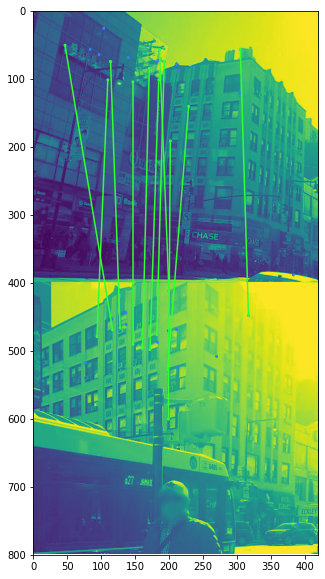

In [4]:
img0, img1, lafs0, lafs1, inliers = inference.run_inference(img0_path, img1_path, experiment_path, checkpoint_name, device)
draw_LAF_matches(
    lafs0,
    lafs1,
    torch.arange(len(inliers)).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img0),
    K.tensor_to_image(img1),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None,
               'feature_color': (0.2, 0.5, 1), 'vertical': True})
plt.savefig(output_dir)

In [ ]:
%load_ext autoreload

In [16]:
%autoreload